# Прогнозирование вероятности дефолта по кредиту на основе кредитной истории заемщиков

Цель: построить ml модель для предсказания дефолта

Задача проекта: улучшить предсказательную силу модели банковского скоринга для принятия решения о том, выдавать ли кредит заемщику или нет (понять, возможен ли дефолт по кредиту).

- EDA
- Поработать над очисткой и обогащением данных
- Оценить важность признаков для модели
- Обучить модель логистической регрессии и спрогнозировать вероятности дефолта
- Применить методы машинного обучения для улучшения прогнозирования вероятности дефолта 
- Настройка гиперпараметров модели
- Участие в соревновании на Kaggle

# Загрузка библиотек

In [1]:
# импортируем необходимые модули

import numpy as np
import pandas as pd

import re
import random
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

from datetime import datetime

from pandas import Series
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_score, KFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_curve,
    roc_auc_score,
    mean_squared_error,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    auc,
    cohen_kappa_score
)

from sklearn.preprocessing import (
    LabelEncoder, 
    OneHotEncoder,
    RobustScaler,
    StandardScaler, 
    OrdinalEncoder, 
    Binarizer, 
    PolynomialFeatures
)

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

from itertools import combinations
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

In [2]:
# показывать больше строк
pd.set_option('display.max_rows', 50)  
# показывать больше колонок
pd.set_option('display.max_columns', 50)  

# Загрузка данных

In [3]:
# файлы входных данных доступны в "../input/"
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
# фиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

In [5]:
data_path = "/Users/varvara/Downloads/sf-dst-scoring/"
# загрузим данные
train = pd.read_csv(data_path + "train.csv")
test = pd.read_csv(data_path + "test.csv")
sample_submission = pd.read_csv(data_path +'sample_submission.csv')

In [6]:
# данные предоставлены двумя отдельными датасетами: тренировочный и тестовый.
# посмотрим на данные
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

(None, None)

In [7]:
print('размерность тренировочного датасета: ', train.shape)
display(train.head(5))
print('размерность тестового датасета: ', test.shape)
display(test.head(5))

размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


0    64427
1     9372
Name: default, dtype: int64

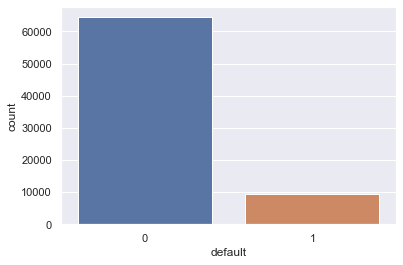

In [8]:
# посмотрим на целевую переменную
ax = sns.countplot(x="default", data=train)

train['default'].value_counts()

Видно, что дефолтных клиетнов значительно меньше, возможно для модели будет легче определить недефолтных клиентов, нужно поработать с признаками, чтобы нормализовать распределение.

# Объединение данных

In [9]:
# для корректной обработки признаков объединяем трейн и тест в один датасет.
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['default'] = 1 # в тесте у нас нет значения default, мы его должны предсказать
# объединяем данные
data = test.append(train, sort=False).reset_index(drop=True) 

# Предобработка

In [10]:
# функция, показывающая распределение данных
def column_info(column):
    print('Информация о столбце {}'.format(column))
    print(f'Количество пустых строк: {data[column].isnull().sum()}')
    print('Распределение столбца:', pd.DataFrame(data[column].value_counts()))
    print(data[column].describe())
    if data[column].dtype == 'int64' or data[column].dtype == 'float64':
        median = data[column].median()
        perc25 = data[column].quantile(0.25)
        perc75 = data[column].quantile(0.75)
        IQR = perc75 - perc25
        print(f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR} Границы выбросов: [{perc25 - 1.5*IQR},{perc75 + 1.5*IQR}]')
        data[column].hist(bins = 10, label = 'IQR')
        plt.legend()
    print('\n')

In [11]:
# оценка статистической значимости с помощью теста Стьюдента
def get_stat_dif(column):
    cols = data.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'default'], 
                        data.loc[data.loc[:, column] == comb[1], 'default']).pvalue \
                            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [12]:
# таблица метрик для сравнения результатов (взято с Kaggle)
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'ROC_AUC']
summary = pd.DataFrame(index=metrics)


def summary_metrics(summary, col, y_valid, y_predicted, y_probs):
    values = [accuracy_score(y_valid, y_predicted), precision_score(y_valid, y_predicted), recall_score(y_valid, y_predicted),
              f1_score(y_valid, y_predicted), roc_auc_score(y_valid, y_probs)]
    summary[col] = values
    return summary

In [ ]:
# строим матрицу ошибок
def conf_mat(y_valid, y_predicted):
    P = np.sum(y_valid==1)
    N = np.sum(y_valid==0)
    print('Positive: {0}, Negative: {1}'.format(P,N))
    
    tn, fp, fn, tp = confusion_matrix(y_valid, y_predicted).ravel()
    print(tp, fp) 
    print(fn, tn)

In [13]:
# преобразуем формат даты
# data.app_date = pd.to_datetime(data.app_date)

# Описание датасета

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Всего 18 признаков в датасете, в том числе бинарная целевая переменная 'default' и добавленный 'sample', из них 6 признаков в виде строк, а 12 числовые. Задача анализа вероятности дефолта является задачей логистической регрессии.


Описание датасета:

1. client_id - идентификатор клиента
2. app_date - дата подачи заявки
3. education - уровень образования
4. sex - пол заемщика
5. age - возраст заемщика
6. car - флаг наличия автомобиля
7. car_type - флаг автомобиля иномарки
8. decline_app_cnt - количество отказанных прошлых заявок
9. good_work - флаг наличия “хорошей” работы
10. score_bki - скоринговый балл по данным из БКИ
11. bki_request_cnt - количество запросов в БКИ
12. region_rating - рейтинг региона
13. home_address - категоризатор домашнего адреса
14. work_address - категоризатор рабочего адреса
15. income - доход заемщика
16. sna - связь заемщика с клиентами банка
17. first_time - давность наличия информации о заемщике
18. foreign_passport - наличие загранпаспорта
19. sample - объединенный
20. default - флаг дефолта по кредиту

In [15]:
# удалим неинформативный признак 'client_id', так как все его значения уникальны 
# и не содержат важную информацию для модели, только порядковый номер
data.drop('client_id', axis=1, inplace=True)

# Удаление пропусков

In [16]:
# посмотрим на пропуски по столбцам
data.isnull().sum().sort_values(ascending=False)

education           478
default               0
score_bki             0
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
bki_request_cnt       0
sample                0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
app_date              0
dtype: int64

Пропусков немного, они есть только в столбце 'education'. Исходя из ранее выполненного задания в baseline, заполним пропуски наиболее часто встречающимся значением.

In [17]:
data['education'] = data['education'].fillna(data.education.mode()[0]) 
data['education'].value_counts()

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

# Анализ, визуализация и обработка данных

Посмотрим на информацию о столбцах, сначала строковых, а потом числовых.

In [18]:
for column in data.columns:
    if data[column].dtypes == 'object':
        print(column_info(column))

Информация о столбце app_date
Количество пустых строк: 0
Распределение столбца:            app_date
18MAR2014      1491
19MAR2014      1363
17MAR2014      1350
31MAR2014      1317
07APR2014      1296
...             ...
20APR2014       359
07JAN2014       349
03JAN2014       313
02JAN2014       204
01JAN2014        56

[120 rows x 1 columns]
count        110148
unique          120
top       18MAR2014
freq           1491
Name: app_date, dtype: object


None
Информация о столбце education
Количество пустых строк: 0
Распределение столбца:      education
SCH      58476
GRD      34768
UGR      14748
PGR       1865
ACD        291
count     110148
unique         5
top          SCH
freq       58476
Name: education, dtype: object


None
Информация о столбце sex
Количество пустых строк: 0
Распределение столбца:      sex
F  61836
M  48312
count     110148
unique         2
top            F
freq       61836
Name: sex, dtype: object


None
Информация о столбце car
Количество пустых строк: 0
Распреде

Видно, что столбец 'app_date' нужно преобразовать и посмотреть, можно ли получить из него важную информацию, разбив дату по месяцам, дням и дням недели. 'education'имеет 5 вариантов, при этом чем выше уровень образования, тем охотнее дают кредит. Видим, что женщин в датасете немного больше, чем мужчин. Значения в 'education', 'sex' стоит привести к числовым показателям. Клиентов с машиной значительно меньше, чем без машины, а клиентов с иномаркой еще меньше. Клиентов с загранпаспортом также намного меньше. Далее посмотрим на значимость этих признаков.

In [19]:
# преобразуем формат даты
data.app_date = pd.to_datetime(data.app_date)
print(data.app_date.head(5))

0   2014-03-22
1   2014-01-24
2   2014-03-23
3   2014-02-03
4   2014-02-04
Name: app_date, dtype: datetime64[ns]


In [20]:
# определяем за какой период данные датасета
data['app_date'].min(), data['app_date'].max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

На основе признака app_date создадим новые признаки:

In [21]:
# год опустим, так как в датасете указаны данные только за 2014
data['app_month'] = data['app_date'].dt.month
data['app_day'] = data['app_date'].dt.day
data['app_wday'] = data['app_date'].dt.weekday

<AxesSubplot:>

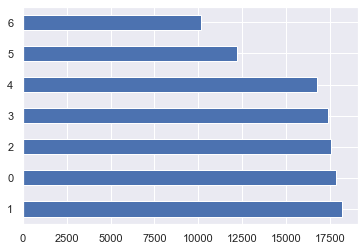

In [22]:
# смотрим на распределение заявок по дням недели
data['app_wday'].value_counts().plot.barh()

In [23]:
# определяем кол-во дефолтных заявок по дате 
date_default_cnt = data['app_date'][data['default']==1].value_counts()
date_default_cnt

2014-03-18    594
2014-03-19    570
2014-03-17    568
2014-04-01    544
2014-04-02    541
             ... 
2014-04-13    148
2014-01-03    144
2014-04-20    141
2014-01-02     85
2014-01-01     19
Name: app_date, Length: 120, dtype: int64

<AxesSubplot:>

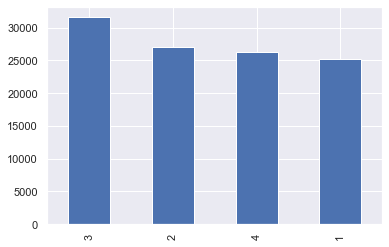

In [24]:
# смотрим на распределение заявок по месяцам
data['app_month'].value_counts().plot.bar()

Заявки по месяцам распределены более-менее равномерно.

In [25]:
# уберем столбец даты в первоначальном виде
data=data.drop(columns=['app_date'])

<AxesSubplot:xlabel='education'>

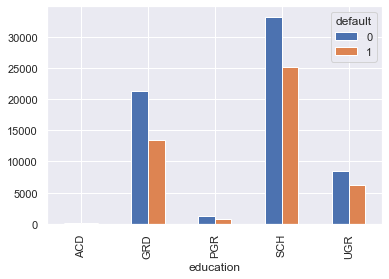

In [26]:
# влияние образования на дефолт
ct = pd.crosstab([data.education], data['default'])
ct.plot(kind='bar')

Чем выше уровень образования у клиента, тем выше вероятность вернуть кредит.

In [27]:
# присвоим числовые значения каждому типу образования
education_dict = {'SCH':1, 'GRD':2, 'UGR':3, 'PGR':4, 'ACD':0, '0':0}

data['education'] = data['education'].replace(to_replace = education_dict)
data['education'].value_counts()
data.head()

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_month,app_day,app_wday
0,2,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,1,3,22,5
1,1,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,1,1,24,4
2,3,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,1,3,23,6
3,1,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,1,2,3,0
4,2,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,1,2,4,1


Информация о столбце age
Количество пустых строк: 0
Распределение столбца:      age
31  4084
28  4035
30  4035
27  3964
29  3940
..   ...
68   261
69   110
70    60
71     6
72     2

[52 rows x 1 columns]
count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64
25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0 Границы выбросов: [3.0,75.0]




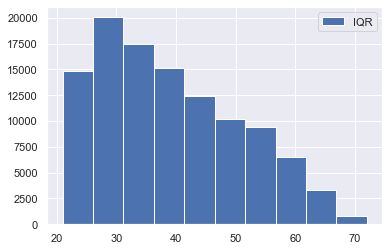

In [28]:
column_info('age')

Возраст имеет значения от 21 года до 72 лет и медианой 37 лет. Большинство кредитов приходится на клиентов в возрасте от 27 до 35 лет. Выделяются клиенты старше 65, меньше заявок. Добаавим новый признак для этих клиентов. Распределение признака стоит нормализовать для лучшей работы модели, явных выбросов нет.

<AxesSubplot:xlabel='default', ylabel='age'>

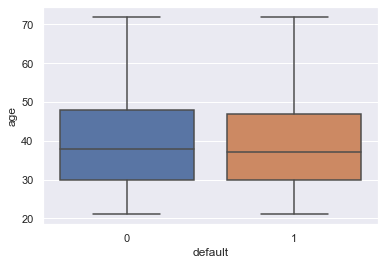

In [29]:
# смотрим на выбросы
sns.boxplot(x='default', y='age', data=data)

Недефолтные клиенты немного старше дефолтных, выбросов нет.

<AxesSubplot:xlabel='count', ylabel='default'>

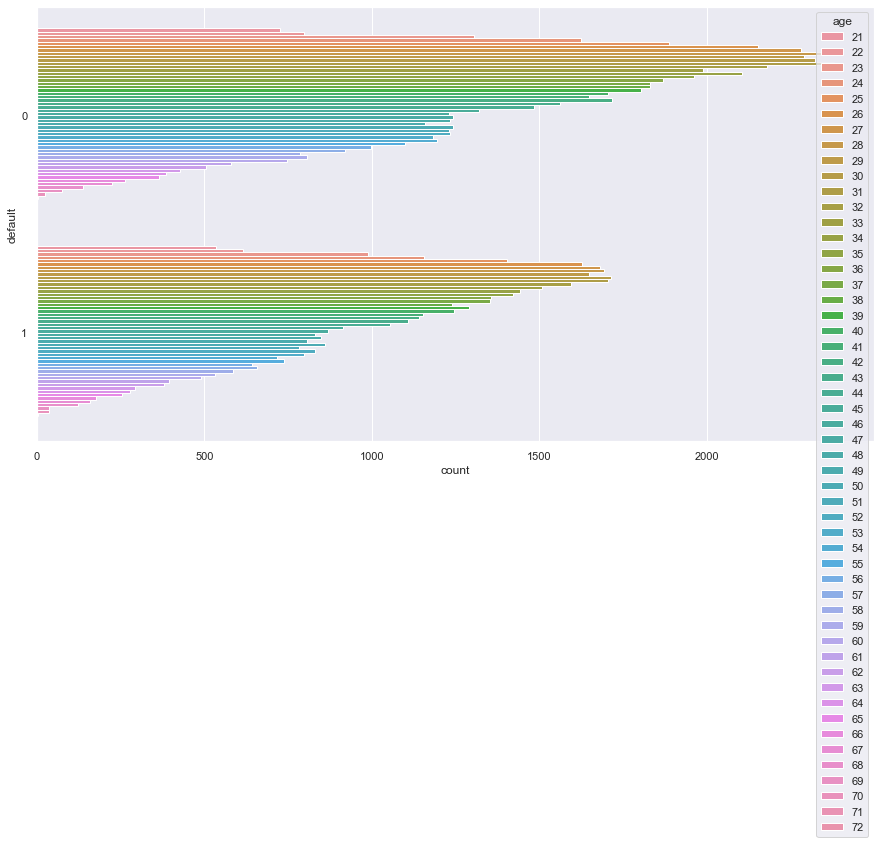

In [30]:
# посмотрим на распределение 'default' в зависимости от возраста
plt.figure(figsize=(15,8))
sns.countplot(y='default', hue='age',data=data)

In [31]:
# добавим новый признак для пожилых клиентов старше 65
data['old_clients'] = data['age'].apply(lambda x: x if x > 65 else None)
# заполним пропуски средним значением
data['old_clients'] = data['old_clients'].fillna(0)
data['old_clients'].value_counts()

0.0     108885
66.0       442
67.0       382
68.0       261
69.0       110
70.0        60
71.0         6
72.0         2
Name: old_clients, dtype: int64

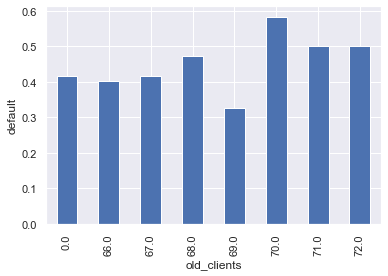

In [32]:
# посмотрим связь пожилых клиентов с дефолтом
data.groupby('old_clients')['default'].mean().plot(kind='bar') 
plt.ylabel('default')
plt.show()

Информация о столбце income
Количество пустых строк: 0
Распределение столбца:         income
30000    10437
25000     9090
20000     8174
40000     7383
50000     6742
...        ...
27478        1
27350        1
20412        1
23120        1
426000       1

[1207 rows x 1 columns]
count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64
25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0 Границы выбросов: [-22000.0,90000.0]




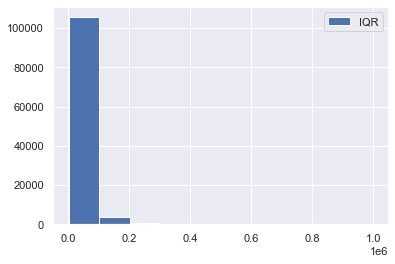

In [33]:
column_info('income')

<AxesSubplot:xlabel='default', ylabel='income'>

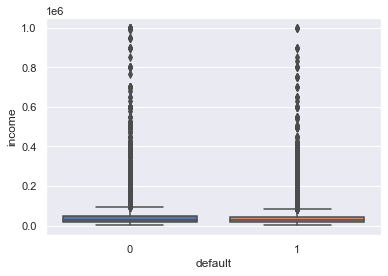

In [34]:
# смотрим на выбросы
sns.boxplot(x='default', y='income', data=data)

Кредиты чаще выдают тем, у кого уровень дохода выше, доход клиентов варьируется от 1000 до 1000000 с медианным показателем 30000. Видно, что распределение смещено, есть выбросы, их много, не стоит удалять такое большое количество данных, попробуем прологарифмировать признак.

Информация о столбце decline_app_cnt
Количество пустых строк: 0
Распределение столбца:     decline_app_cnt
0             91471
1             12500
2              3622
3              1365
4               606
5               255
6               156
7                58
8                37
9                29
10               16
11               10
12                5
13                4
14                3
16                3
30                1
15                1
19                1
20                1
21                1
22                1
24                1
33                1
count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64
25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0 Границы выбросов: [0.0,0.0]




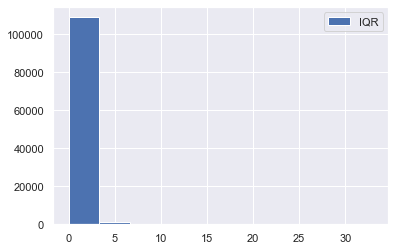

In [35]:
column_info('decline_app_cnt') 

<AxesSubplot:xlabel='default', ylabel='decline_app_cnt'>

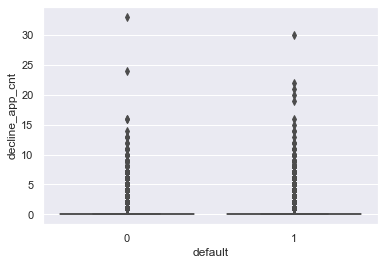

In [36]:
# смотрим на выбросы
sns.boxplot(x='default', y='decline_app_cnt', data=data)

Распределение также смещено вправо,у дефолтных клиентов количество отклоненных заявок выше, чем у недефолтных, большинству клиентов раньше не отказывали в кредите, есть небольшое количество клиентов, кому отказывали много раз, максимально 33 раза.

Информация о столбце good_work
Количество пустых строк: 0
Распределение столбца:    good_work
0      91917
1      18231
count    110148.000000
mean          0.165514
std           0.371645
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: good_work, dtype: float64
25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0 Границы выбросов: [0.0,0.0]




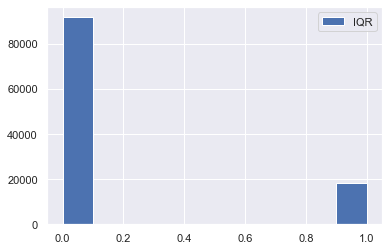

In [37]:
column_info('good_work')

<AxesSubplot:xlabel='default', ylabel='good_work'>

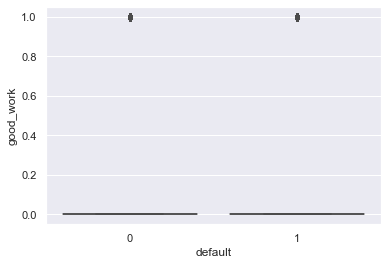

In [38]:
# смотрим на выбросы
sns.boxplot(x='default', y='good_work', data=data)

Клиентов с хорошей работой значительно меньше, они более кредитоспособны.

Информация о столбце score_bki
Количество пустых строк: 0
Распределение столбца:            score_bki
-1.775263        517
-2.104211        454
-2.225004        424
-2.169664        375
-2.024100        278
...              ...
-1.916044          1
-2.142259          1
-1.227466          1
-2.709566          1
-2.295169          1

[102618 rows x 1 columns]
count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64
25-й перцентиль: -2.2604336700000003, 75-й перцентиль: -1.5678881525, IQR: 0.6925455175000004 Границы выбросов: [-3.299251946250001,-0.5290698762499992]




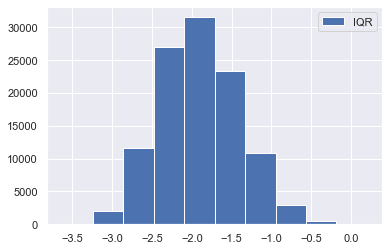

In [39]:
 column_info('score_bki')

<AxesSubplot:xlabel='default', ylabel='score_bki'>

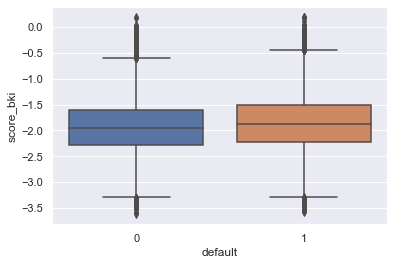

In [40]:
# смотрим на выбросы
sns.boxplot(x='default', y='score_bki', data=data)

Средний скоринговый балл тех, кому отказали - выше, в целом распределение выглядит нормально,  но есть выбросы. UPD их удаление приводит к потере данных, худшему предсказанию, поэтому оставим их.

Информация о столбце bki_request_cnt
Количество пустых строк: 0
Распределение столбца:     bki_request_cnt
0             28908
1             27295
2             20481
3             13670
4              8406
5              4960
6              2500
7              1292
8               735
9               459
10              350
11              278
12              217
13              151
14              110
15               81
16               58
17               33
18               32
19               30
21               19
20               14
23               12
24               12
22                8
25                5
27                5
28                5
26                4
32                4
29                3
33                2
40                2
41                1
46                1
45                1
47                1
36                1
34                1
53                1
count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
2

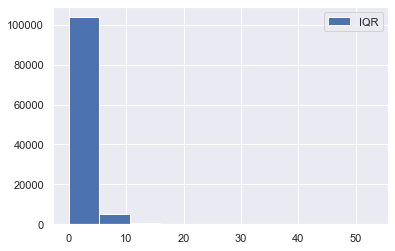

In [41]:
column_info('bki_request_cnt') 

<AxesSubplot:xlabel='default', ylabel='bki_request_cnt'>

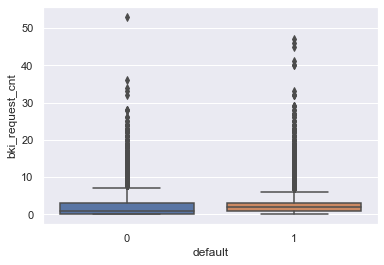

In [42]:
# смотрим на выбросы
sns.boxplot(x='default', y='bki_request_cnt', data=data)

Количество запросов в БКИ у дефолтных клиентов выше, 75% клиентов имеют значение менее 3 запросов, а есть клиенты с большим количеством запросов, максимальное значение - 53 запроса. Есть выбросы.

Информация о столбце region_rating
Количество пустых строк: 0
Распределение столбца:     region_rating
50          40981
60          23999
40          17947
80          17170
70           9304
30            434
20            313
count    110148.000000
mean         56.751189
std          13.065923
min          20.000000
25%          50.000000
50%          50.000000
75%          60.000000
max          80.000000
Name: region_rating, dtype: float64
25-й перцентиль: 50.0, 75-й перцентиль: 60.0, IQR: 10.0 Границы выбросов: [35.0,75.0]




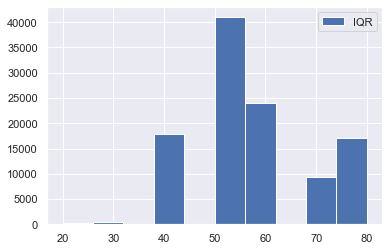

In [43]:
column_info('region_rating')  

<AxesSubplot:xlabel='default', ylabel='region_rating'>

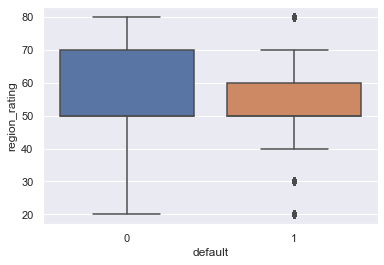

In [44]:
# смотрим на выбросы
sns.boxplot(x='default', y='region_rating', data=data)

Рейтинг региона варьируется от 20 до 80. Далее преобразуем значения этого признака.

<AxesSubplot:xlabel='count', ylabel='default'>

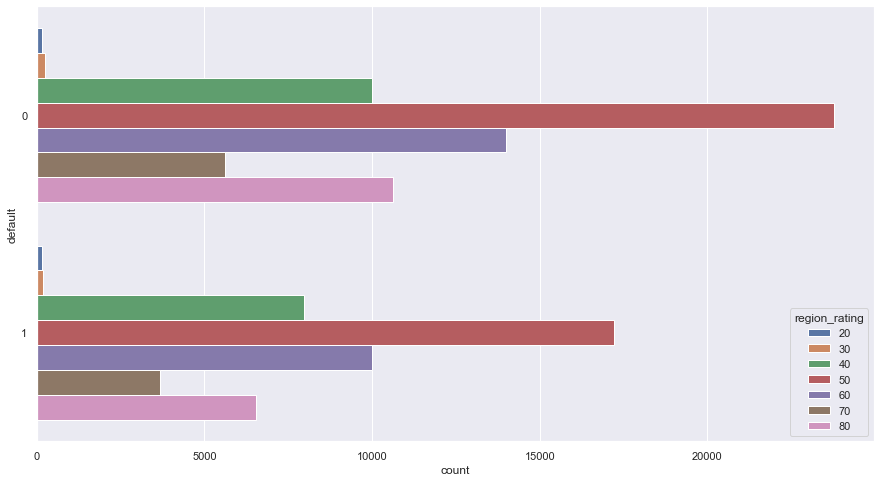

In [45]:
# попробуем посмотреть на распределение 'default' в зависимости от рейтинга региона
plt.figure(figsize=(15,8))
sns.countplot(y='default', hue='region_rating',data=data)

Информация о столбце home_address
Количество пустых строк: 0
Распределение столбца:    home_address
2         59591
1         48688
3          1869
count    110148.000000
mean          1.574945
std           0.527562
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: home_address, dtype: float64
25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0 Границы выбросов: [-0.5,3.5]




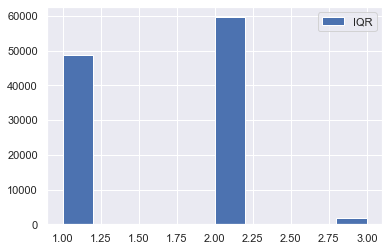

In [46]:
column_info('home_address')  

<AxesSubplot:xlabel='default', ylabel='home_address'>

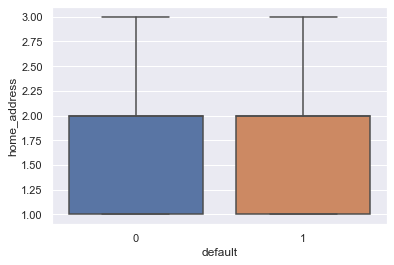

In [47]:
# смотрим на выбросы
sns.boxplot(x='default', y='home_address', data=data)

Домашние адреса также распределены по 3 категориям. Клиенты, проживающие в 3 категории адреса более кредитоспособны, чем проживающие в 1 и 2 категориях.

Информация о столбце work_address
Количество пустых строк: 0
Распределение столбца:    work_address
3         67113
2         30761
1         12274
count    110148.000000
mean          2.497867
std           0.687651
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           3.000000
Name: work_address, dtype: float64
25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0 Границы выбросов: [0.5,4.5]




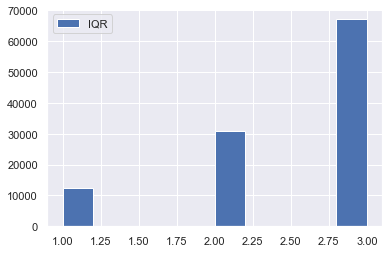

In [48]:
column_info('work_address')  

<AxesSubplot:xlabel='default', ylabel='work_address'>

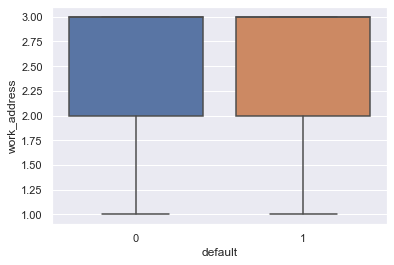

In [49]:
# смотрим на выбросы
sns.boxplot(x='default', y='work_address', data=data)

Информация о столбце sna
Количество пустых строк: 0
Распределение столбца:      sna
1  70681
4  17481
2  15832
3   6154
count    110148.000000
mean          1.731588
std           1.122652
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           4.000000
Name: sna, dtype: float64
25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0 Границы выбросов: [-0.5,3.5]




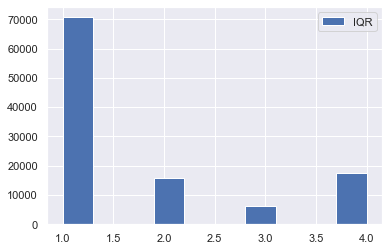

In [50]:
column_info('sna')    

<AxesSubplot:xlabel='default', ylabel='sna'>

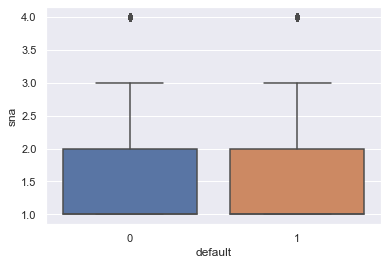

In [51]:
# смотрим на выбросы
sns.boxplot(x='default', y='sna', data=data)

Чем больше связь заемщика с клиентами банка, тем выше риск невозврата кредита

Информация о столбце first_time
Количество пустых строк: 0
Распределение столбца:    first_time
3       46588
4       28017
1       18296
2       17247
count    110148.000000
mean          2.765570
std           1.010151
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           4.000000
Name: first_time, dtype: float64
25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0 Границы выбросов: [-1.0,7.0]




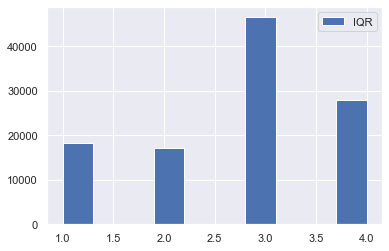

In [52]:
column_info('first_time')  

<AxesSubplot:xlabel='default', ylabel='first_time'>

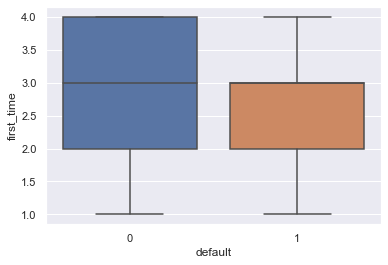

In [53]:
# смотрим на выбросы
sns.boxplot(x='default', y='first_time', data=data)

Чем выше показатель, тем более надежнее клиент.

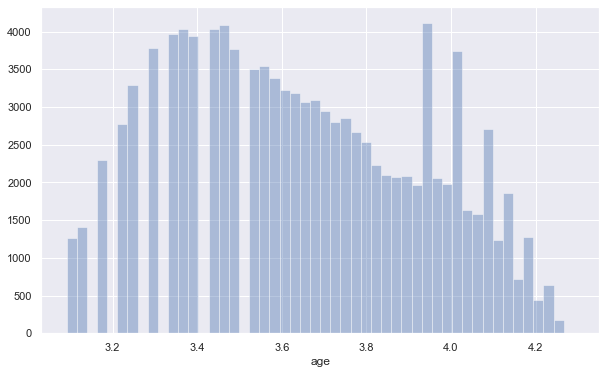

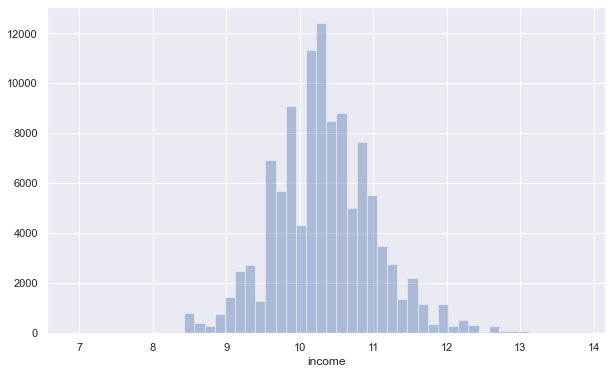

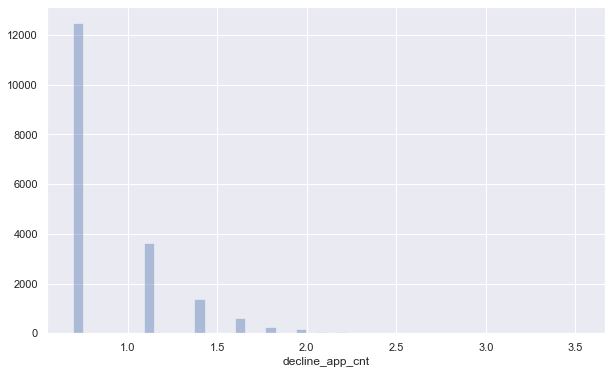

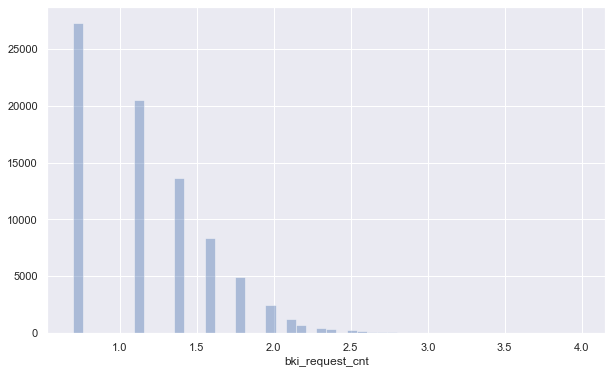

In [54]:
# прологорифмируем признаки и пробуем нормализовать их распределение
cols_log = ['age','income', 'decline_app_cnt','bki_request_cnt']
for i in cols_log:
    data[i] = np.log(data[i] + 1)
    plt.figure(figsize=(10,6))
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.show()

Вывод: логарифмирование помогло улучшить распределение признаков.

# Разбивка признаки по типам

In [55]:
# определим тип признаков датасета
data.nunique()

education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
app_month                4
app_day                 31
app_wday                 7
old_clients              8
dtype: int64

Признаки с большим количеством уникальных значений отнесем к числовым.
К бинарным отнесем признаки, у которых два уникальных значения. Остальные отнесем к категориальным.

In [56]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna',  'first_time','app_month','app_wday', 'old_clients']

num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'app_day']

target_col = ['default']

<AxesSubplot:xlabel='default', ylabel='count'>

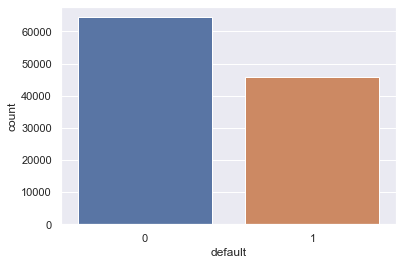

In [57]:
# распределение целевой переменной
sns.countplot(data["default"])

После логарифмирования признаков, распределение целевого признака выглядит значительно лучше.

# Числовые признаки

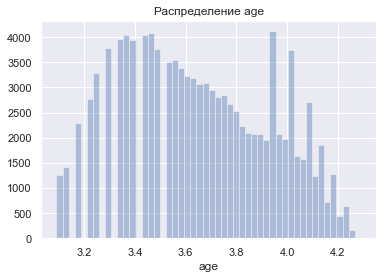

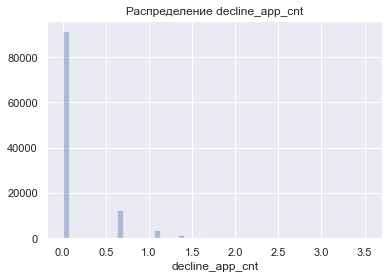

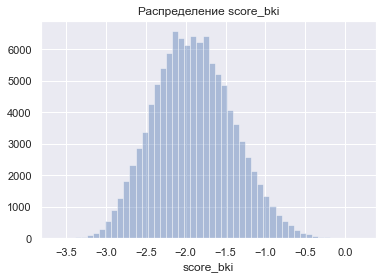

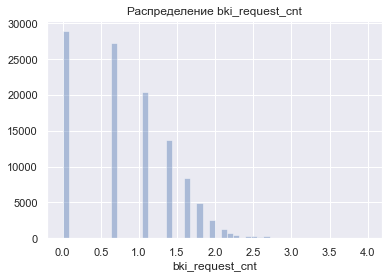

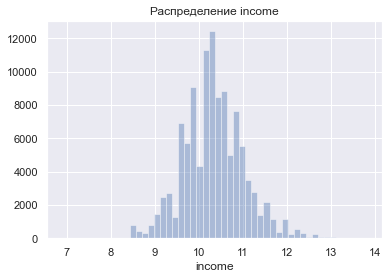

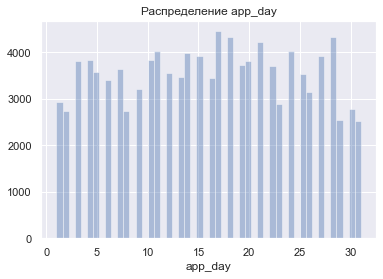

In [58]:
# посмотрим на распределение числовых переменных
for col in num_cols:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(data[col], kde=False)

In [59]:
data[num_cols].describe()

,age,decline_app_cnt,score_bki,bki_request_cnt,income,app_day
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,3.654546,0.151330,-1.904535,0.878752,10.345792,15.959100
std,0.285054,0.361331,0.499397,0.658667,0.696636,8.598467
min,3.091042,0.000000,-3.624586,0.000000,6.908755,1.000000
25%,3.433987,0.000000,-2.260434,0.000000,9.903538,9.000000
50%,3.637586,0.000000,-1.920823,0.693147,10.308986,16.000000
75%,3.891820,0.000000,-1.567888,1.386294,10.778977,23.000000
max,4.290459,3.526361,0.199773,3.988984,13.815512,31.000000


<AxesSubplot:>

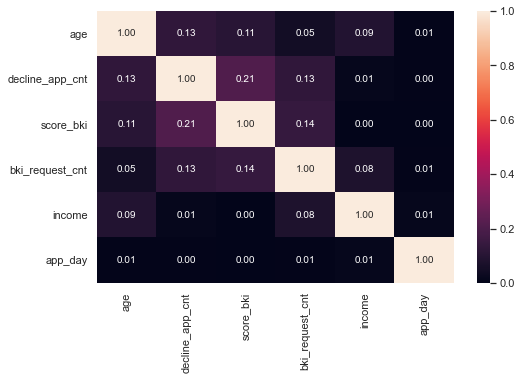

In [60]:
# посмотрим на корреляцию признаков между собой
plt.figure(figsize=(8, 5))
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, annot=True, fmt=".2f")

Так как значения корреляции небольшие, следует оставить все признаки. Ниабольшая корреляция 0.21 между скоринговым баллом по данным из БКИ и количеством запросов в БКИ.

Text(0.5, 1.0, 'Значимость числовых признаков')

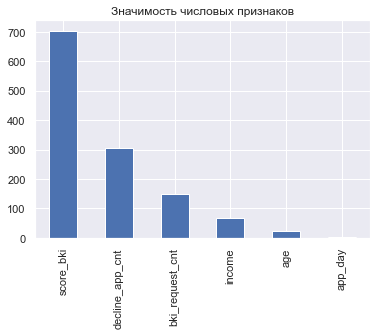

In [61]:
# используем дисперсионный анализ для определения значимости числовых признаков
imp_num = pd.Series(f_classif(data[num_cols], data["default"])[0], index=num_cols)
imp_num.sort_values(inplace=True, ascending=False)
imp_num.plot(kind="bar")
plt.title('Значимость числовых признаков')

In [ ]:
for col in num_cols:
    get_stat_dif(col)

Наибольшее влияние на вероятность дефолта имеет количество отказанных прошлых заявок, очень маленькое влияние - день подачи заявки. Удалим этот признак из модели

In [62]:
data=data.drop(columns=['app_day'])

In [63]:
new_num_cols = ['decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'age']

Стандартизируем числовые переменные:

In [64]:
# стандартизация числовых переменных
x_num = StandardScaler().fit_transform(train[new_num_cols].values)

# Бинарные признаки

Для преобразования бинарных признаков мы будем использовать LabelEncoder.

In [65]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_month,app_wday,old_clients
0,2,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0,0,1,3,5,0.0
1,1,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0,0,1,1,4,0.0
2,3,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,50,1,2,10.308986,1,3,1,0,1,3,6,0.0
3,1,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,40,1,2,9.741027,1,3,0,0,1,2,0,0.0
4,2,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,80,2,3,11.695255,1,3,0,0,1,2,1,0.0


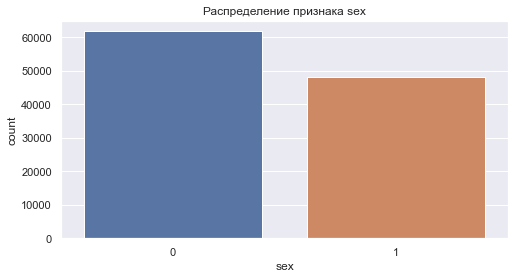

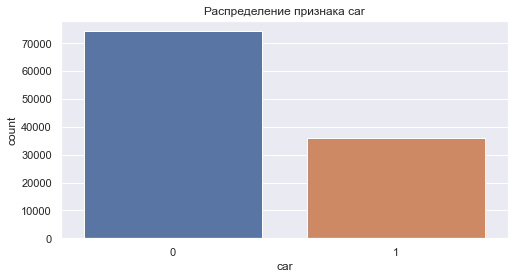

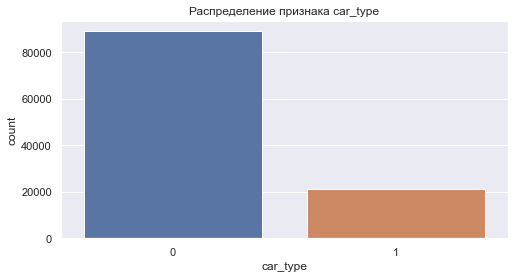

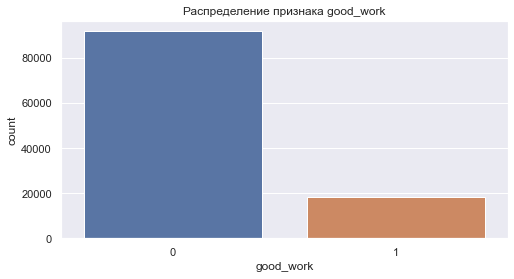

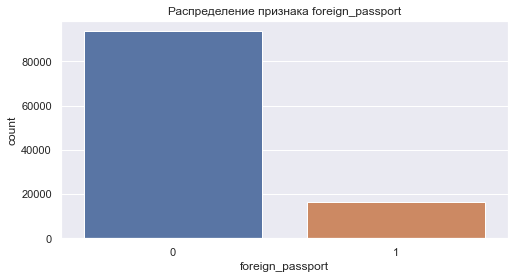

In [66]:
# посмотрим распределение бинарных признаков
for col in bin_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data[col])
    plt.title(f"Распределение признака {col}")

Проверим, есть ли статистическая разница в распределении дефолтных клиентов по бинарным признакам, с помощью теста Стьюдента.

In [67]:
for col in bin_cols:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки car
Найдены статистически значимые различия для колонки car_type
Найдены статистически значимые различия для колонки good_work
Найдены статистически значимые различия для колонки foreign_passport


Text(0.5, 1.0, 'Значимость бинарных признаков')

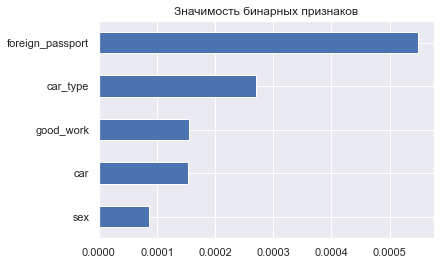

In [68]:
# значимость бинарных признаков
imp_bin = Series(mutual_info_classif(data[bin_cols], data['default'],
                                     discrete_features =True), index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')
plt.title('Значимость бинарных признаков')

Видно, что самый значимый признак - это наличие загранпаспорта и иномарки.

# Категориальные признаки

Преобразуем категориальные переменные при помощи OneHotEncoder.

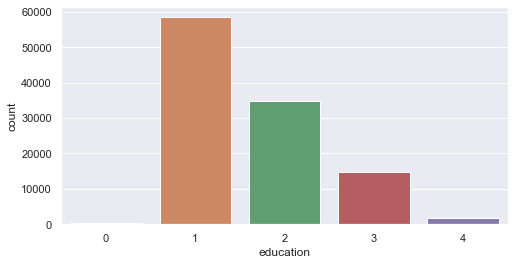

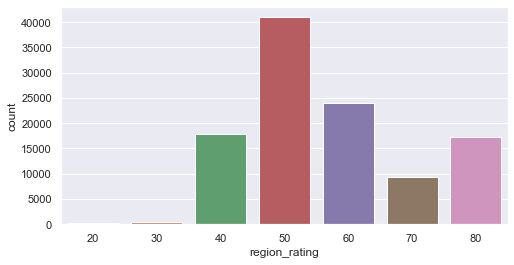

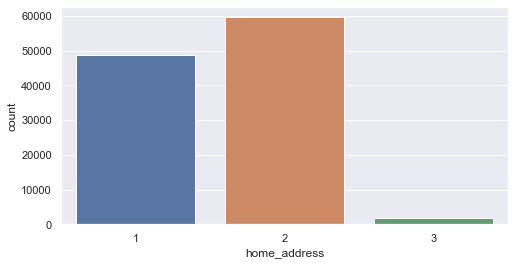

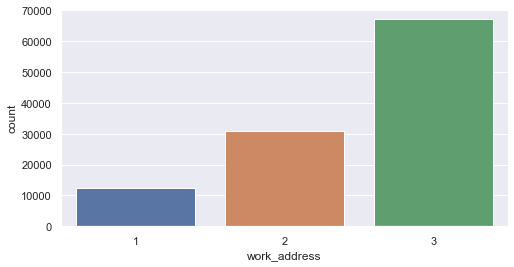

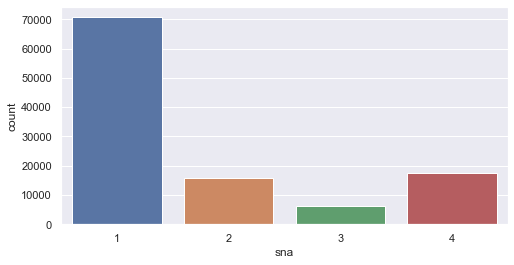

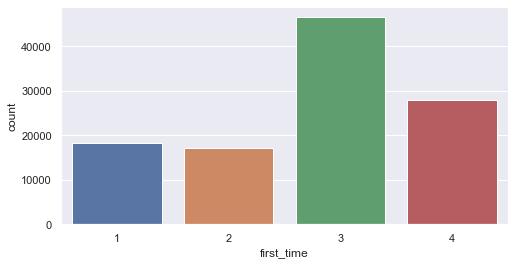

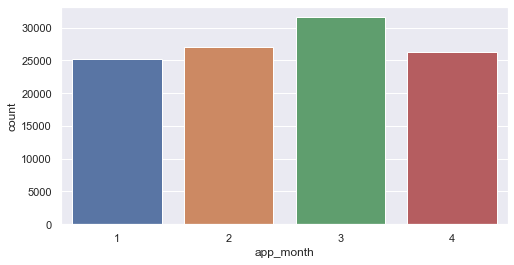

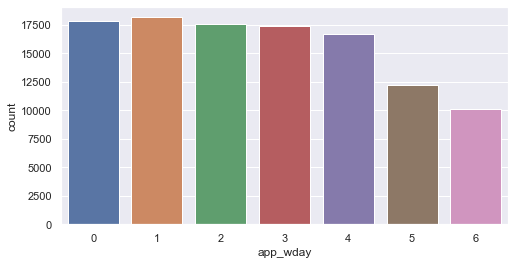

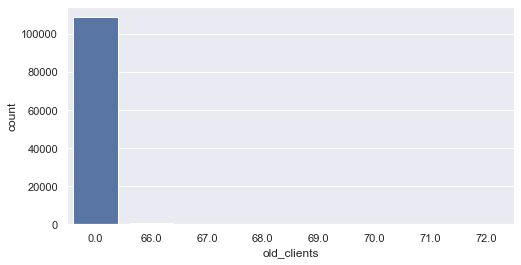

In [69]:
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data[col])
    plt.titlelabel_encoder = LabelEncoder()

In [70]:
# преобразуем категориальные переменные при помощи OneHotEncoder.
x_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)
x_cat.shape
print(x_cat.shape)

(110148, 45)


Text(0.5, 1.0, 'Значимость категориальных признаков')

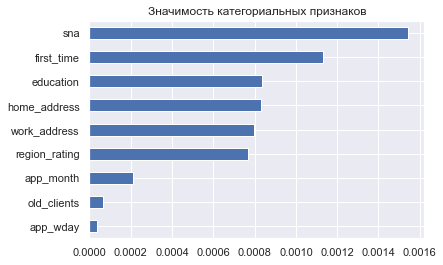

In [71]:
# определим значимость категориальных признаков
imp_cat = pd.Series(mutual_info_classif(pd.concat([data[cat_cols]], axis=1),
                                        data['default'], discrete_features =True),
                    index = pd.concat([data[cat_cols]], axis=1).columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.title('Значимость категориальных признаков')

Видно, что самый значимый признак - это связь заемщика с клиентами банка.

Перекодируем все категориальные переменные в dummy:

In [72]:
# закодируем категориальные признаки при помощи get_dummy
data_cat = pd.get_dummies(data.loc[:, cat_cols], columns=cat_cols)
data_cat.sample(5)

,education_0,education_1,education_2,education_3,education_4,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,app_month_1,app_month_2,app_month_3,app_month_4,app_wday_0,app_wday_1,app_wday_2,app_wday_3,app_wday_4,app_wday_5,app_wday_6,old_clients_0.0,old_clients_66.0,old_clients_67.0,old_clients_68.0,old_clients_69.0,old_clients_70.0,old_clients_71.0,old_clients_72.0
48137,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
5279,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
14478,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
72588,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
23464,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [73]:
for col in cat_cols:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки education
Найдены статистически значимые различия для колонки region_rating
Найдены статистически значимые различия для колонки home_address
Найдены статистически значимые различия для колонки work_address
Найдены статистически значимые различия для колонки sna
Найдены статистически значимые различия для колонки first_time
Найдены статистически значимые различия для колонки app_month
Найдены статистически значимые различия для колонки old_clients


Проверяем данные после преобразования:

In [74]:
data[new_num_cols].head(5)  

,decline_app_cnt,score_bki,bki_request_cnt,income,age
0,0.000000,-2.271884,1.386294,10.819798,3.401197
1,1.791759,-1.504999,1.098612,8.517393,3.688879
2,0.000000,-1.691339,0.693147,10.308986,3.931826
3,0.000000,-2.374182,0.693147,9.741027,4.043051
4,0.000000,-2.487502,0.000000,11.695255,3.663562


In [75]:
data[bin_cols].head(5)  

,sex,car,car_type,good_work,foreign_passport
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,1,0,1
3,1,0,0,0,0
4,0,0,0,0,0


In [76]:
data2 = data.drop(new_num_cols, axis=1)
data1 = data2.drop(bin_cols, axis=1)
data1.head(5)

,education,region_rating,home_address,work_address,sna,first_time,sample,default,app_month,app_wday,old_clients
0,2,50,1,2,1,4,0,1,3,5,0.0
1,1,50,1,2,4,3,0,1,1,4,0.0
2,3,50,1,2,1,3,0,1,3,6,0.0
3,1,40,1,2,1,3,0,1,2,0,0.0
4,2,80,2,3,1,3,0,1,2,1,0.0


Все перемнные выглядят хорошо.

# Обучение модели логистической регрессии

 1. Наивная модель

In [77]:
# разделим на train и test, т.к. все признаки уже обработаны
train_data = data[data['sample'] == 1].drop(['sample'], axis=1)
test_data = data[data['sample'] == 0].drop(['sample'], axis=1)

In [78]:
# выделим целевую переменную и признаки
X = train_data.drop(['default'], axis=1).values
y = train_data['default'].values

In [79]:
# разделим на тренировочные и валидационные выборки
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3,
                                                  random_state=42, stratify=y)


In [80]:
# обучим модель
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [81]:
y_predicted = model.predict(X_valid)
print('accuracy: ', accuracy_score(y_valid,y_predicted))
print('precision: ', precision_score(y_valid,y_predicted))
print('recall: ', recall_score(y_valid,y_predicted))
print('f1_score: ', f1_score(y_valid,y_predicted))

accuracy:  0.8726287262872628
precision:  0.47701149425287354
recall:  0.029516358463726886
f1_score:  0.05559276624246484


Получился низкий recall, модель плохо определяет дефолтных клиентов; необходимо сбалансировать данные и сократить количество недефолтных клиентов.

Модель_1

In [82]:
# выделим целевую переменную и признаки
X = train_data.drop(['default'], axis=1).values
y = train_data['default'].values

In [83]:
# изменяем выборку с помощью undersampling
data_undersamp = RandomUnderSampler(random_state=42)
X, y = data_undersamp.fit_resample(X, y)

In [84]:
# разделим на тренировочные и валидационные выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

In [85]:
model_1 = LogisticRegression(random_state=42, max_iter=1000)
model_1.fit(X_train, y_train)  # обучаем модель

LogisticRegression(max_iter=1000, random_state=42)

In [86]:
# предсказываем вероятности 
probs = model_1.predict_proba(X_valid) # вероятностные оценки
y_probs = probs[:, 1]

y_predicted = model_1.predict(X_valid)  # предсказываем сами значения

In [87]:
# посмотрим метрики базовой модели
summary_metrics(summary, 'model_1', y_valid, y_predicted, y_probs)

,model_1
accuracy,0.662162
precision,0.665818
recall,0.651138
f1_score,0.658396
ROC_AUC,0.725141


In [88]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True)

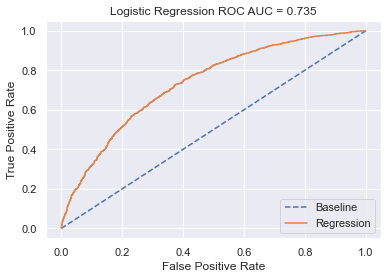

In [89]:
probs = model_1.predict_proba(X_test)
probs = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

# визуализация ROC AUC
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [91]:
# и выведем confusion matrix
conf_mat(y_valid, y_predicted)

Positive: 2812, Negative: 2812
1831 919
981 1893


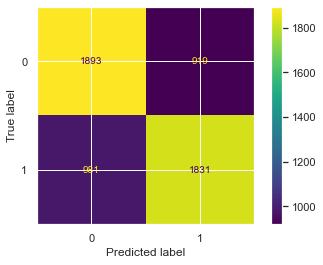

In [92]:
# визуализируем матрицу
plot_confusion_matrix(model_1, X_valid, y_valid)

Вывод: модель хорошо определяет дефолтных 1893 и недефолтных клиентов 1831, при этом 981 ложноотрицательных(предсказали, что отдадут кредит, а они не отдали) и 919 ложноположительных (предсказали, что не отдадут кредит, а они отдали).

Модель_2

Попробуем настроить гиперпараметры (взято из slack)

In [93]:
model = LogisticRegression(random_state=42)
param_grid = [
    {'penalty': ['l1'],
     'solver': ['liblinear', 'lbfgs'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']},
    {'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']},
    {'penalty': ['none'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
# печатаем параметры
best_parameters = model.get_params()

In [94]:
# оптимальные параметры
for param_name in best_parameters.keys():
    print(f'  {param_name} = {best_parameters[param_name]},')

  C = 1.0,
  class_weight = balanced,
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 100,
  multi_class = auto,
  n_jobs = None,
  penalty = none,
  random_state = 42,
  solver = newton-cg,
  tol = 0.0001,
  verbose = 0,
  warm_start = False,


In [95]:
# обучаем модель с оптимальными гиперпараметрами
model_2 = LogisticRegression(C=1.0,
                                       class_weight=None,
                                       dual=False,
                                       fit_intercept=True,
                                       intercept_scaling=1,
                                       l1_ratio=None,
                                       max_iter=100,
                                       multi_class='auto',
                                       n_jobs=None,
                                       penalty='none',
                                       random_state=42,
                                       solver='lbfgs',
                                       tol=0.0001,
                                       verbose=0,
                                       warm_start=False)

model_2.fit(X_train, y_train)

LogisticRegression(penalty='none', random_state=42)

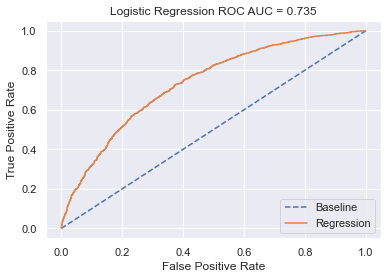

In [96]:
probs = model_2.predict_proba(X_valid)
y_probs = probs[:, 1]
y_pred = model_2.predict(X_valid)

# визуализация ROC AUC
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [97]:
probs = model_2.predict_proba(X_valid)
y_probs = probs[:, 1]
y_pred = model_2.predict(X_valid)

# сравним метрики с предыдущими моделью
# метрики практически не изменились
summary_metrics(summary, 'model_2', y_valid, y_predicted, y_probs)

,model_1,model_2
accuracy,0.662162,0.662162
precision,0.665818,0.665818
recall,0.651138,0.651138
f1_score,0.658396,0.658396
ROC_AUC,0.725141,0.724383


Модель_3 

Код взят с платформы.

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True)

In [101]:
# разделим на тренировочные и валидационные выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

In [103]:
# добавим типы регуляризации
penalty = ['l1', 'l2']

# зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model_3 = LogisticRegression()
model_3.fit(X_train, y_train)

# создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# смотрим на лучшие гиперпараметры
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 59.94842503189409


In [104]:
# обучаем модель с этими гиперпараметрами
model_3 = LogisticRegression(
    penalty='l2', C=59.94842503189409, max_iter=1000)
model_3.fit(X_train, y_train)

LogisticRegression(C=59.94842503189409, max_iter=1000)

In [105]:
probs = model_3.predict_proba(X_valid)
y_probs = probs[:, 1]
y_pred = model_3.predict(X_valid)

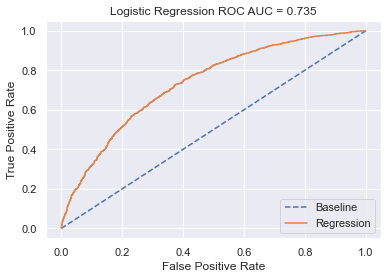

In [107]:
probs = model_3.predict_proba(X_valid)
y_probs = probs[:, 1]
y_pred = model_3.predict(X_valid)

# визуализация ROC AUC
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [106]:
# сравним метрики с предыдущими моделями
summary_metrics(summary, 'model_3', y_valid, y_predicted, y_probs)

,model_1,model_2,model_3
accuracy,0.662162,0.662162,0.662162
precision,0.665818,0.665818,0.665818
recall,0.651138,0.651138,0.651138
f1_score,0.658396,0.658396,0.658396
ROC_AUC,0.725141,0.724383,0.725151


Вывод:результаты предсказания лучше в третьей модели после поиска оптимальных параметров регуляризации, улучшилась предсказательная сила логистической регрессии.

# Submission

In [109]:
X_test = test_data.drop(['default'], axis=1)
y_pred_prob = model_3.predict_proba(X_test)[:, 1]
submit = pd.DataFrame(test.client_id)
submit['default'] = y_pred_prob
submit.to_csv('submission_model_3.csv', index=False)
submit

,client_id,default
0,74835,0.240814
1,17527,0.791883
2,75683,0.252395
3,26883,0.380677
4,28862,0.166303
...,...,...
36344,83775,0.797229
36345,106254,0.126279
36346,81852,0.811359
36347,1971,0.616889
